# Final Project

#### Team: &emsp;&emsp; Sasi Kanduri &emsp;&emsp; Vikas Mishra &emsp;&emsp; Ashish Kotian

### Converting .mat files to jpg and image arrays
##### The dataset we chose is from the follwoing link which has images in .mat files. We have to take the image arrays out of the .mat constructs and pre-process them.

In [113]:
import os
import h5py
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import SimpleITK as sitk
# # List of directories to process
# directories = [
#     'brainTumorDataPublic_1-766',
#     'brainTumorDataPublic_767-1532',
#     'brainTumorDataPublic_1533-2298',
#     'brainTumorDataPublic_2299-3064'
# ]

y_labels = []
filename_column = []

image_arrays = []
image_classes = []
image_size = 256


# Set the paths for the Mat and Jpg folders
mat_folder = f'./all_files'
jpg_folder = f'./Jpg_images'

# Create the Jpg folder if it doesn't exist
# if not os.path.exists(jpg_folder):
#     os.makedirs(jpg_folder)

# Iterate through files in the Mat folder
for filename in os.listdir(mat_folder):
    # Construct the full file paths
    mat_filepath = os.path.join(mat_folder, filename)
    jpg_filepath = os.path.join(jpg_folder, filename.split(".")[0] + '.jpg')

    # Open the mat file
    with h5py.File(mat_filepath, 'r+') as f:

        cjdata = f['cjdata']
        image = np.array(cjdata.get('image')).astype(np.float64)
        label = cjdata.get('label')[0, 0]
        
        if image.shape[0] == 512:
            
            y_labels.append(label - 1)
            filename_column.append(filename.split(".")[0])

            # Perform image processing
            hi = np.max(image)
            lo = np.min(image)
            image = (((image - lo) / (hi - lo)) * 255).astype(np.uint8)

            image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
            image_arrays.append(image)
            image_classes.append(label - 1)

            # cv2.imwrite(jpg_filepath, image)
            # t1_image = sitk.GetImageFromArray(image)
            # sitk.WriteImage(t1_image, jpg_filepath)

    
df = pd.DataFrame({'filename':filename_column, 'label':y_labels})
df.to_csv('final_df.csv', index=False)

#### sample image

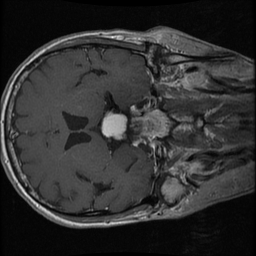

In [114]:
Image.fromarray(image_arrays[0], 'L')

### Data pre-processing

In [115]:
import numpy as np
from numpy import array
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, Rescaling
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


import tensorflow as tf

In [116]:
image_arrays = np.array(image_arrays).astype(np.uint8)
image_arrays = image_arrays.reshape(image_arrays.shape[0], image_size, image_size, 1)

grayscale_tensors = tf.convert_to_tensor(image_arrays)
rgb_images = tf.image.grayscale_to_rgb(grayscale_tensors)
rgb_images = np.array(rgb_images).astype(np.uint8)

In [117]:
rgb_images[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [2, 2, 2],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        ...,
        [1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [118]:
image_classes_encoded = tf.keras.utils.to_categorical(image_classes, 3)
image_classes_encoded = image_classes_encoded.astype(np.uint8)


In [119]:
x_train, x_test, y_train, y_test = train_test_split(rgb_images, image_classes_encoded, test_size=0.2, shuffle=True, random_state=42)

### Using the Vision Transformer pretrained model - vit_b16 

#### This model converts the input image into 16x16 patches to be feeded to the encoder block

In [120]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

#### Visualizing the patches for a sample image

Patch size: 16 X 16
Patches per image: 256
Elements per patch: 768


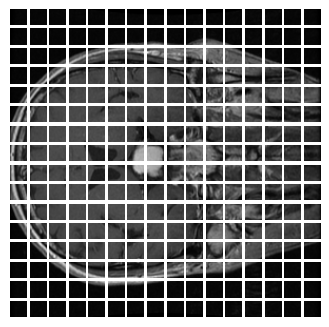

In [121]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([rgb_images[0]]), size = (image_size, image_size)
)

patches = Patches(16)(resized_image)

print(f'Patch size: {16} X {16}')

print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

###  Building ViT model

In [122]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = (image_size, image_size),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

vit_model.summary()

/Users/shashi/Documents/219-ML/mlenv/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 768)       590592    
                                                                 
 reshape_8 (Reshape)         (None, 256, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 257, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 257, 768)          197376    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 257, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [123]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = 'gelu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = 'gelu'),
        tf.keras.layers.Dense(32, activation = 'gelu'),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_4 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_8 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 128)               98432     
                                                                 
 batch_normalization_9 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 64)         

In [124]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x_train, y_train,
          validation_data = (x_test, y_test),
          epochs = 50,
          callbacks = early_stopping_callbacks)

Epoch 1/50
 9/77 [==>...........................] - ETA: 7:37 - loss: 1.1760 - accuracy: 0.4201

KeyboardInterrupt: 